## Designing and Training Model

In [204]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
import tensorflow as tf
from scipy.ndimage import zoom
from sklearn.metrics import r2_score


In [66]:
image_dir = Path('20-50/20-50')
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int)
image_data = pd.DataFrame({"filename":filepaths, "age": ages})

In [121]:
sampled_image_data = image_data.sample(15000).reset_index(drop=True)

test, train = train_test_split(sampled_image_data, test_size=0.8, shuffle=True)

In [122]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=float(1/255),
    horizontal_flip=True,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=float(1/255),
    horizontal_flip=True,
)

train_flow = train_gen.flow_from_dataframe(
    dataframe=train,
    x_col='filename',
    y_col='age',
    target_size=(126, 126),
    color_mode='grayscale',
    shuffle=True,
    class_mode='raw',
    subset='training'
)


val_flow = train_gen.flow_from_dataframe(
    dataframe=train,
    x_col='filename',
    y_col='age',
    target_size=(126, 126),
    color_mode='grayscale',
    shuffle=True,
    class_mode='raw',
    subset='validation'
)

test_flow = train_gen.flow_from_dataframe(
    dataframe=test,
    x_col='filename',
    y_col='age',
    target_size=(126, 126),
    color_mode='grayscale',
    shuffle=False,
    class_mode='raw',
)

Found 9600 validated image filenames.
Found 2400 validated image filenames.
Found 3000 validated image filenames.


In [143]:
inputs = tf.keras.Input(shape=(126, 126, 1))

x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', strides=2, padding="same")(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = tf.keras.layers.MaxPool2D()(x)
final_conv_layer = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = tf.keras.layers.GlobalAvgPool2D()(final_conv_layer)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
result = tf.keras.layers.Dense(1, activation='linear')(x)

In [216]:
model = tf.keras.Model(inputs=inputs, outputs=[result, final_conv_layer])
model.compile(
    optimizer='Adam',
    loss=['MAE',None]
)
model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 126, 126, 1)]     0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 63, 63, 16)        160       
_________________________________________________________________
max_pooling2d_152 (MaxPoolin (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 31, 31, 32)        4640      
_________________________________________________________________
max_pooling2d_153 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_154 (MaxPoolin (None, 7, 7, 64)          0  

In [146]:
history = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=75,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/75
300/300 [==============================] - 13s 43ms/step - loss: 8.0382 - dense_75_loss: 8.0382 - val_loss: 8.0566 - val_dense_75_loss: 8.0566

## Model Results on Test Data

In [149]:
test_mae = model.evaluate(test_flow)
print("Test MAE:", test_mae)

94/94 [==============================] - 2s 17ms/step - loss: 7.5099 - dense_75_loss: 7.5099

In [153]:
predicted_ages = np.squeeze(model.predict(test_flow)[0])
correct_ages = test_flow.labels
r2 = r2_score(correct_ages, predicted_ages)
print("R2 Score:", r2)

R2 Score: 0.034817187953613105


In [152]:
null_rmse = np.sum(np.abs(correct_ages - np.mean(correct_ages))) / len(correct_ages)
print("Null Model Test RMSE: {:.5f}".format(null_rmse))

Null/Baseline Model Test RMSE: 7.71778


### Visualizing CNN CAM

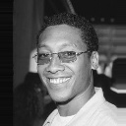

In [194]:
img = Image.open("20-50/20-50/test/36/38623.jpg")
img = ImageOps.grayscale(img)
img = img.resize((126, 126))
img

In [197]:
imgarr = np.asarray(img)
imgarr = np.multiply(imgarr.reshape((1, 126, 126, 1)), 1./255)
predict, conv = model.predict(imgarr)
print("Predicted Age:", predict[0][0])
print("Real Age:", 36)

Predicted Age: 32.911213
Real Age: 36


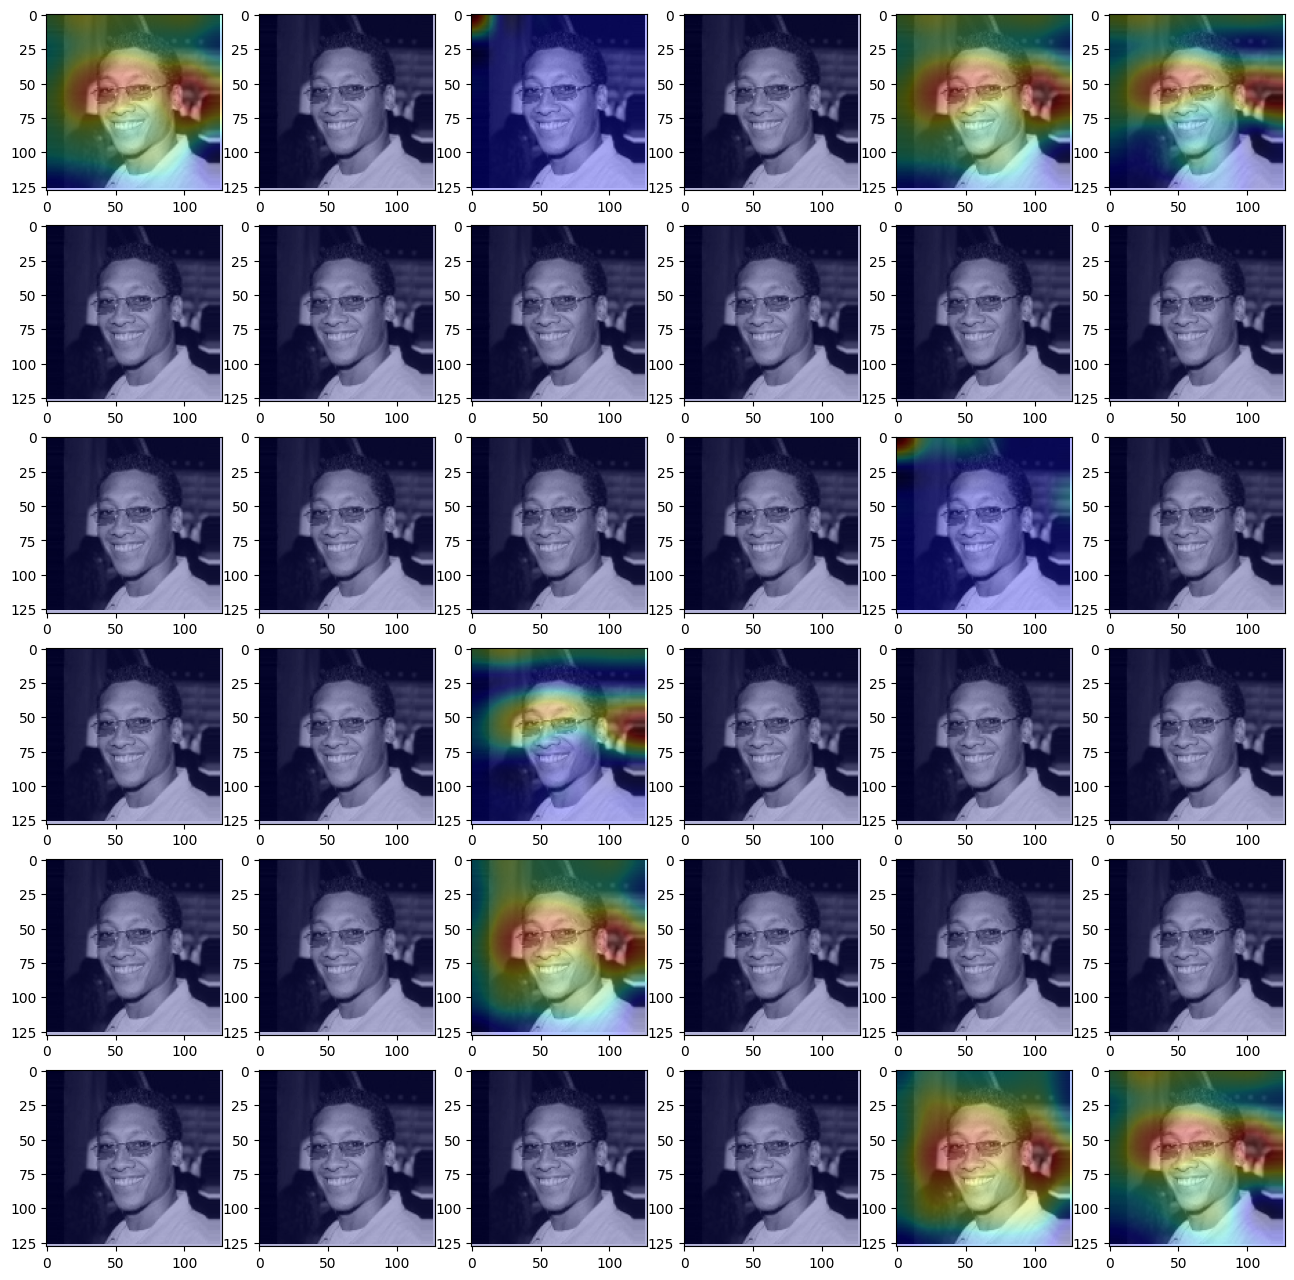

In [245]:
scale = 128 / 7
plt.figure(figsize=(16, 16))
plt.title("Class Activation Mapping for Img 38623")
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(img, cmap='gray')
    plt.imshow(zoom(conv[0, :,:,i], zoom=(scale, scale)), cmap='jet', alpha=0.3)

In [279]:
w1, b1 = model.get_layer("dense_73").weights
w2, b2 = model.get_layer("dense_74").weights
weights = w1[:, 0].numpy()
heatmap = conv.squeeze() @ weights
np.array(heatmap).shape

(7, 7)

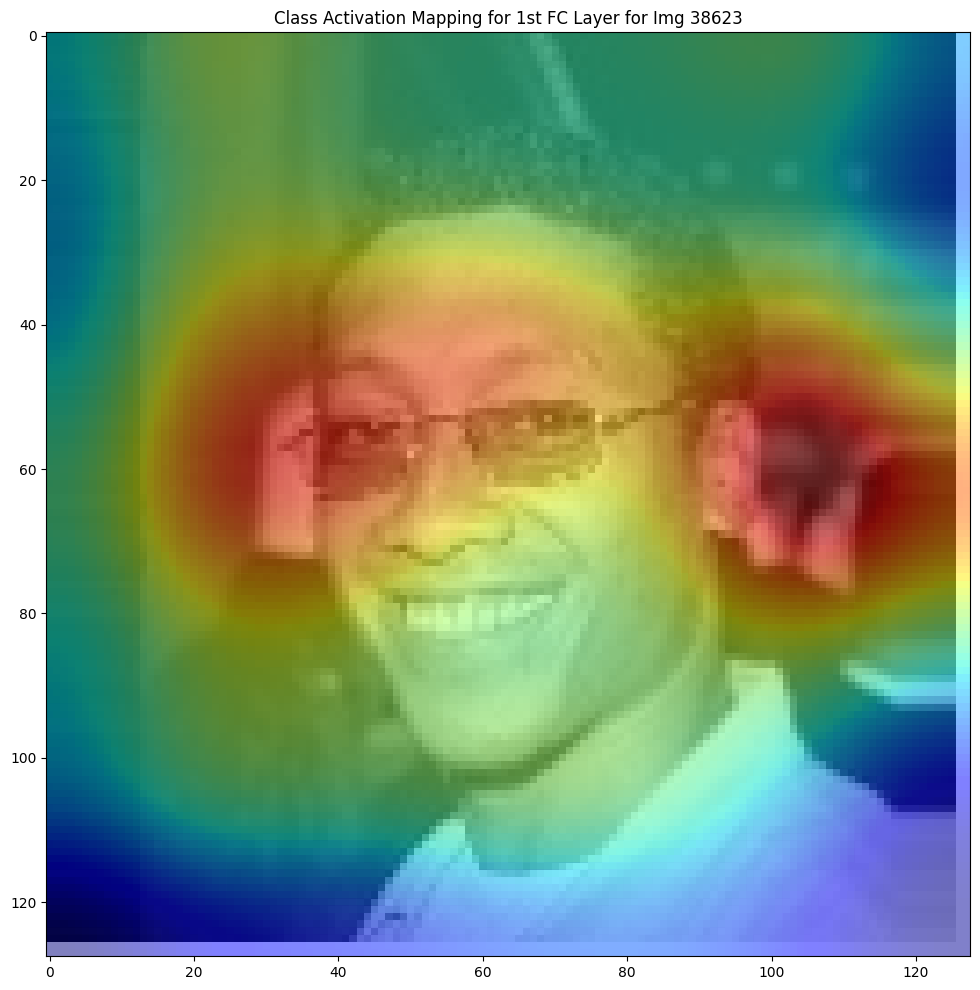

In [280]:
scale = 128 / 7
plt.figure(figsize=(12, 12))
plt.title("Class Activation Mapping for 1st FC Layer for Img 38623")
plt.imshow(img, cmap='gray')
plt.imshow(zoom(heatmap, zoom=(scale, scale)), cmap='jet', alpha=0.5)

In [281]:
model.save("20_50_age_prediction.keras")
